In [ ]:
!pip install pandas numpy statsmodels xgboost matplotlib seaborn tqdm scikit-learn

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.23.5
!pip install pmdarima --no-cache-dir --force-reinstall


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

In [ ]:
def load_and_reshape_data(file_path, sku_to_predict, warehouse_id, region):

    try:
        data = pd.read_csv(file_path)

        # Filter by specified SKU, Warehouse, and Region
        data = data[data['SKU id'] == sku_to_predict]
        data = data[data['Warehouse id'] == warehouse_id]
        data = data[data['Region'] == region]

        # Melt the DataFrame to long format
        id_vars = ['Warehouse id', 'Region', 'SKU id']
        value_vars = [col for col in data.columns if col not in id_vars] # month names
        data_melted = pd.melt(data, id_vars=id_vars, value_vars=value_vars, var_name='Date', value_name='Sales')

        # Convert 'Date' column to datetime
        data_melted['Date'] = pd.to_datetime(data_melted['Date'], format='%b-%y') # Correct format

        # Set 'Date' as index
        data_melted = data_melted.set_index('Date')
        data_melted = data_melted[['Sales']]  # Keep only the Sales column
        data_melted = data_melted.asfreq('MS')

        return data_melted

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except KeyError as e:
        print(f"Error: Column not found: {e}")
        return None

# Example Usage:
file_path = 'Data (1).csv'
sku_to_predict = 'SKU-1'
warehouse_id = 'Wh-1'
region = 'NORTH'

data = load_and_reshape_data(file_path, sku_to_predict, warehouse_id, region)

if data is None:
    print("Data loading failed. Exiting.")
    exit()
print(data.head())

            Sales
Date             
2018-04-01     27
2018-05-01     13
2018-06-01     30
2018-07-01     14
2018-08-01     22


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

# Component 1: Data Loading and Reshaping
def load_and_reshape_data(file_path, sku_to_predict, warehouse_id, region):
    """Loads, reshapes, and filters the data."""
    try:
        data = pd.read_csv(file_path)
        data = data[(data['SKU id'] == sku_to_predict) &
                    (data['Warehouse id'] == warehouse_id) &
                    (data['Region'] == region)]

        id_vars = ['Warehouse id', 'Region', 'SKU id']
        value_vars = [col for col in data.columns if col not in id_vars]
        data_melted = pd.melt(data, id_vars=id_vars, value_vars=value_vars, var_name='Date', value_name='Sales')
        data_melted['Date'] = pd.to_datetime(data_melted['Date'], format='%b-%y')
        data_melted = data_melted.set_index('Date')[['Sales']].asfreq('MS')
        return data_melted
    except (FileNotFoundError, KeyError) as e:
        print(f"Error loading data: {e}")
        return None

# Component 2: Split into Train and Test
def split_train_test(data, test_size=0.2):
    train_size = int(len(data) * (1 - test_size))
    return data.iloc[:train_size], data.iloc[train_size:]

# Component 3: SARIMA Modeling and Forecasting
def fit_sarima_and_forecast(train_data, test_data, auto=True):
    """Fits SARIMA model and generates forecasts."""
    try:
        if auto:
            auto_arima_model = auto_arima(train_data['Sales'], seasonal=True, m=12,
                                           trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)
            best_order = auto_arima_model.order
            best_seasonal_order = auto_arima_model.seasonal_order
        else:
            best_order = (1, 1, 1)
            best_seasonal_order = (0, 1, 0, 12)

        sarima_model = SARIMAX(train_data['Sales'], order=best_order, seasonal_order=best_seasonal_order)
        sarima_result = sarima_model.fit(disp=False)

        sarima_in_sample = sarima_result.get_prediction(start=train_data.index[0], end=train_data.index[-1]).predicted_mean
        sarima_predictions = pd.Series(sarima_result.get_forecast(steps=len(test_data)).predicted_mean, index=test_data.index)

        return sarima_predictions, sarima_in_sample, sarima_result

    except Exception as e:
        print(f"Error in SARIMA modeling: {e}")
        return None, None, None


# Component 4: Evaluation (Optional)
def evaluate_forecast(test_data, sarima_predictions):
    """Evaluates the SARIMA forecast."""
    try:
        rmse = np.sqrt(mean_squared_error(test_data['Sales'], sarima_predictions))
        mae = mean_absolute_error(test_data['Sales'], sarima_predictions)
        print(f"SARIMA Model RMSE: {rmse}\nSARIMA Model MAE: {mae}")
    except Exception as e:
        print(f"Error in evaluating forecast: {e}")

# Execute Workflow
file_path = 'Data (1).csv'
sku_to_predict = 'SKU-1'
warehouse_id = 'Wh-1'
region = 'NORTH'

data = load_and_reshape_data(file_path, sku_to_predict, warehouse_id, region)
if data is None: exit()

train, test = split_train_test(data)

sarima_predictions, sarima_in_sample, sarima_result = fit_sarima_and_forecast(train, test)
if sarima_predictions is None: exit()

evaluate_forecast(test, sarima_predictions)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.23 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=223.219, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=225.856, Time=0.46 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=225.854, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=254.739, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=224.664, Time=0.31 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=224.590, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=224.366, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=224.457, Time=0.77 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=226.351, Time=0.98 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 7.101 seconds
SARIMA Model RMSE: 10.700467279516348
SARIMA Model MAE: 10.25



--- Loading Data ---
File: Data (1).csv, SKU: SKU-1, Wh: Wh-1, Region: NORTH
Data loaded successfully. Shape: (38, 1)

Data Head:
            Sales
Date             
2018-04-01     27
2018-05-01     13
2018-06-01     30
2018-07-01     14
2018-08-01     22

--- Splitting Data ---
Train size: 30, Test size: 8

--- Fitting SARIMA Model ---
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=226.351, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=223.219, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=225.856, Time=2.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=225.854, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=254.739, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=224.664, Time=0.23 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=224.590, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=224.366, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] in

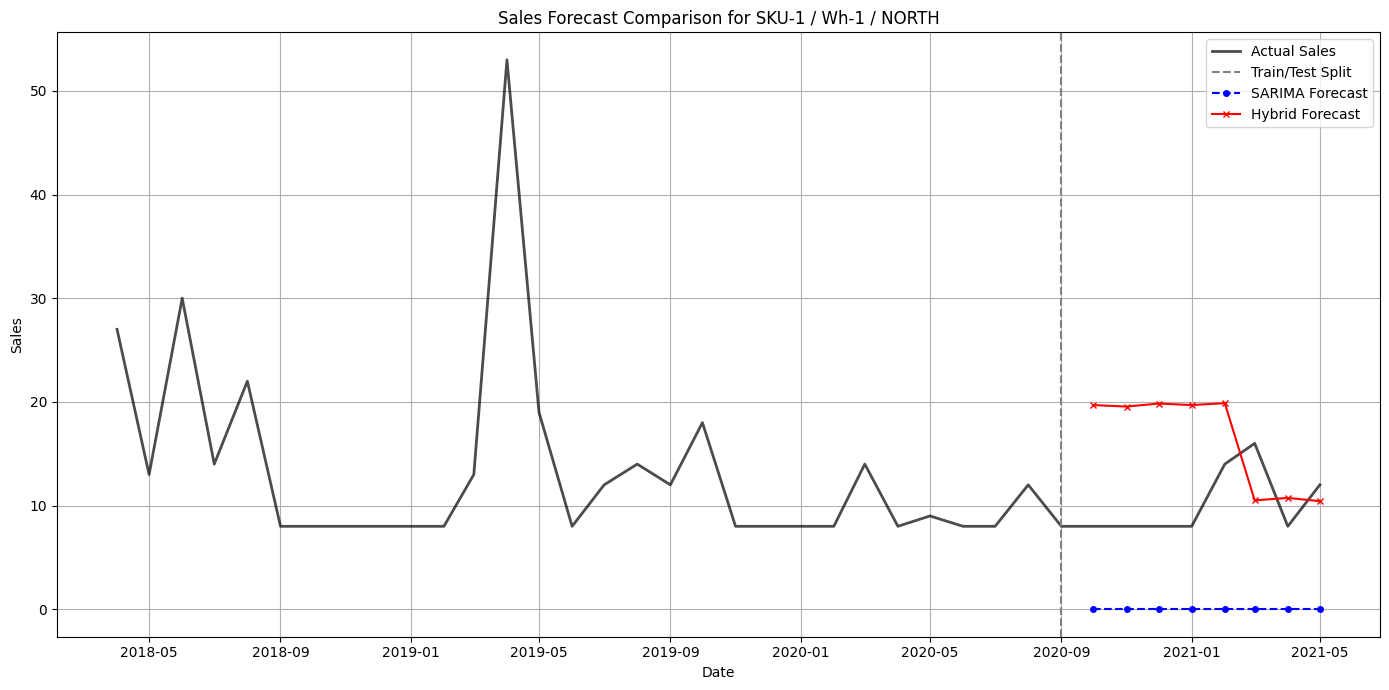


Workflow finished.


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split # Needed for XGBoost validation split
from pmdarima import auto_arima
import xgboost as xgb
import warnings
import traceback
import matplotlib.pyplot as plt # Import for plotting

warnings.filterwarnings("ignore")

# --- Component 1: Data Loading and Reshaping (Unchanged) ---
def load_and_reshape_data(file_path, sku_to_predict, warehouse_id, region):
    """Loads, reshapes, and filters the data."""
    print(f"\n--- Loading Data ---")
    print(f"File: {file_path}, SKU: {sku_to_predict}, Wh: {warehouse_id}, Region: {region}")
    try:
        data = pd.read_csv(file_path)
        data = data[(data['SKU id'] == sku_to_predict) &
                    (data['Warehouse id'] == warehouse_id) &
                    (data['Region'] == region)]

        if data.empty:
             print(f"Error: No data found for SKU: {sku_to_predict}, Warehouse: {warehouse_id}, Region: {region}")
             return None

        id_vars = ['Warehouse id', 'Region', 'SKU id']
        value_vars = [col for col in data.columns if col not in id_vars]
        data_melted = pd.melt(data, id_vars=id_vars, value_vars=value_vars, var_name='Date', value_name='Sales')
        try:
            data_melted['Date'] = pd.to_datetime(data_melted['Date'], format='%b-%y')
        except ValueError:
             print("Warning: Failed parsing date with '%b-%y', trying '%Y-%m-%d' or letting pandas infer.")
             data_melted['Date'] = pd.to_datetime(data_melted['Date'])

        data_melted = data_melted.sort_values('Date')
        data_melted = data_melted.set_index('Date')[['Sales']].asfreq('MS')
        if data_melted['Sales'].isnull().any():
            print(f"Warning: NaNs found after setting frequency. Filling with 0.")
            data_melted['Sales'] = data_melted['Sales'].fillna(0)

        print(f"Data loaded successfully. Shape: {data_melted.shape}")
        return data_melted
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None
    except KeyError as e:
        print(f"Error: Column missing in data file - {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        traceback.print_exc()
        return None

# --- Component 2: Split into Train and Test (Unchanged) ---
def split_train_test(data, test_size=0.2):
    """Splits data chronologically into train and test sets."""
    print("\n--- Splitting Data ---")
    if len(data) < 5:
        print("Error: Not enough data points (less than 5) to perform train/test split.")
        return None, None
    if test_size <= 0 or test_size >= 1:
         print("Error: test_size must be between 0 and 1 (exclusive).")
         return None, None

    split_point = int(len(data) * (1 - test_size))
    split_point = max(1, min(split_point, len(data) - 1))
    train_data = data.iloc[:split_point]
    test_data = data.iloc[split_point:]

    if train_data.empty or test_data.empty:
        print(f"Error: Train or test set is empty after split. Total points: {len(data)}, Split point: {split_point}")
        return None, None

    print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")
    return train_data, test_data

# --- Component 3a: Feature Engineering for XGBoost (Unchanged) ---
def create_features(df, target_col='Sales', lags=12):
    """Creates time series features from the datetime index and lags."""
    print(f"Creating features with lags up to {lags}...")
    df_feat = df.copy()
    df_feat['month'] = df_feat.index.month
    df_feat['year'] = df_feat.index.year
    df_feat['quarter'] = df_feat.index.quarter
    for lag in range(1, lags + 1):
        df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)

    df_feat['rolling_mean_3'] = df_feat[target_col].shift(1).rolling(window=3, min_periods=1).mean()
    df_feat['rolling_mean_6'] = df_feat[target_col].shift(1).rolling(window=6, min_periods=1).mean()
    df_feat['rolling_mean_12'] = df_feat[target_col].shift(1).rolling(window=12, min_periods=1).mean()

    print(f"Shape before dropping NaNs from lags: {df_feat.shape}")
    rows_to_drop = lags
    df_feat = df_feat.iloc[rows_to_drop:]
    print(f"Shape after dropping NaNs from lags: {df_feat.shape}")

    if df_feat.isnull().any().any():
         print("Warning: NaNs still present after dropping initial lag rows. Filling with 0.")
         df_feat = df_feat.fillna(0)

    return df_feat

# --- Component 3b: SARIMA Modeling and Forecasting (Unchanged) ---
def fit_sarima_and_forecast(train_data, test_data, auto=True):
    """Fits SARIMA model and generates forecasts."""
    print("\n--- Fitting SARIMA Model ---")
    try:
        if auto:
            min_obs_for_seasonal = 2 * 12 + 2
            if len(train_data['Sales']) < min_obs_for_seasonal:
                 print(f"Warning: Training data size ({len(train_data)}) is less than recommended ({min_obs_for_seasonal}) for robust auto_arima seasonality detection (m=12). Setting m=1.")
                 m_param = 1
                 seasonal_flag = False
            else:
                 m_param = 12
                 seasonal_flag = True

            auto_arima_model = auto_arima(train_data['Sales'],
                                           seasonal=seasonal_flag, m=m_param,
                                           start_p=1, start_q=1, max_p=3, max_q=3,
                                           start_P=0, max_P=2, start_Q=0, max_Q=2,
                                           d=None, D=None,
                                           trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)
            best_order = auto_arima_model.order
            best_seasonal_order = auto_arima_model.seasonal_order
            print(f"AutoARIMA selected Order: {best_order}, Seasonal Order: {best_seasonal_order}")
        else:
            best_order = (1, 1, 1)
            best_seasonal_order = (0, 1, 0, 12)
            print(f"Using fixed Order: {best_order}, Seasonal Order: {best_seasonal_order}")

        train_data_freq = train_data.asfreq('MS')
        if train_data_freq['Sales'].isnull().any():
            print("Warning: NaNs found in training data after ensuring frequency. Filling with 0 for SARIMAX.")
            train_data_freq['Sales'] = train_data_freq['Sales'].fillna(0)

        sarima_model = SARIMAX(train_data_freq['Sales'], order=best_order, seasonal_order=best_seasonal_order,
                               enforce_stationarity=False, enforce_invertibility=False)
        sarima_result = sarima_model.fit(disp=False)
        print(sarima_result.summary())

        # Get in-sample predictions on the training set
        sarima_in_sample_pred = sarima_result.get_prediction(start=train_data_freq.index[0], end=train_data_freq.index[-1])
        sarima_in_sample = sarima_in_sample_pred.predicted_mean.reindex(train_data.index) # Align index with original train_data

        # Forecast for the test period
        forecast_steps = len(test_data)
        sarima_forecast_obj = sarima_result.get_forecast(steps=forecast_steps)
        sarima_predictions = pd.Series(sarima_forecast_obj.predicted_mean, index=test_data.index) # Align index with test_data

        print("SARIMA fitting and forecasting complete.")
        return sarima_predictions, sarima_in_sample, sarima_result

    except Exception as e:
        print(f"Error in SARIMA modeling: {e}")
        traceback.print_exc()
        return None, None, None

# --- Component 3c: XGBoost for Residuals Forecasting (NEW/MODIFIED) ---
def fit_xgboost_on_residuals(data, train_idx, test_idx, sarima_in_sample, target_col='Sales', val_size=0.15):


    print("\n--- Fitting XGBoost on SARIMA Residuals ---")
    try:
        # 1. Calculate Residuals on Training Data
        # Align SARIMA predictions with the original training data index before subtracting
        common_resid_idx = train_idx.intersection(sarima_in_sample.index)
        if len(common_resid_idx) < len(train_idx):
             print(f"Warning: SARIMA in-sample predictions index ({len(sarima_in_sample)}) doesn't fully match train index ({len(train_idx)}). Using {len(common_resid_idx)} common points for residuals.")
        if len(common_resid_idx) == 0:
             print("Error: Cannot calculate residuals. No overlap between train data and SARIMA in-sample predictions.")
             return None, None

        train_residuals = data.loc[common_resid_idx, target_col] - sarima_in_sample.loc[common_resid_idx]
        train_residuals = train_residuals.rename("Residuals") # Name the series

        if train_residuals.isnull().any():
            print("Warning: NaNs found in training residuals. Filling with 0.")
            train_residuals = train_residuals.fillna(0)

        # 2. Create Features from ORIGINAL data (spanning train and test)
        num_lags = 12 # Use the same lag structure as before (or adjust if needed)
        featured_data = create_features(data, target_col=target_col, lags=num_lags)
        X_features = featured_data.drop(columns=[target_col]) # Features only

        # 3. Align Features and Residuals (Target for XGBoost)
        # Get features corresponding to the time points where we calculated residuals
        X_train_resid_feat = X_features.reindex(train_residuals.index).dropna() # Features for residual training
        y_train_resid = train_residuals.reindex(X_train_resid_feat.index) # Ensure target aligns with available features

        # Get features corresponding to the *original* test set index
        X_test_feat = X_features.reindex(test_idx).dropna() # Features for residual forecasting

        if X_train_resid_feat.empty or y_train_resid.empty:
             print("Error: No training data remains for XGBoost after aligning features and residuals.")
             return None, None
        if X_test_feat.empty:
             print("Error: No test data features remain for XGBoost after alignment.")
             return None, None

        print(f"XGBoost Residual Training Feature Shape: {X_train_resid_feat.shape}")
        print(f"XGBoost Residual Target Shape: {y_train_resid.shape}")
        print(f"XGBoost Residual Test Feature Shape: {X_test_feat.shape}")

        # 4. Split Residual Training Data for XGBoost Validation/Early Stopping
        # Use train_test_split on the *residual* training data (features and target)
        if len(X_train_resid_feat) * val_size < 1:
            print("Warning: Not enough data for validation split in XGBoost residual training. Using full training set for fitting without early stopping.")
            X_train_xgb, y_train_xgb = X_train_resid_feat, y_train_resid
            eval_set = None
            early_stopping_rounds = None
        else:
            X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
                X_train_resid_feat, y_train_resid, test_size=val_size, shuffle=False # DO NOT shuffle time series data
            )
            print(f"XGBoost internal train size: {len(X_train_xgb)}, validation size: {len(X_val_xgb)}")
            eval_set = [(X_train_xgb, y_train_xgb), (X_val_xgb, y_val_xgb)]
            early_stopping_rounds = 10

        # 5. Train XGBoost Model to Predict Residuals
        xgb_resid_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            n_estimators=200, # Can potentially increase this when using early stopping
            learning_rate=0.05, # Often lower learning rates work well with more estimators
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=early_stopping_rounds # Use the variable set above
        )

        print("Training XGBoost on residuals...")
        xgb_resid_model.fit(X_train_xgb, y_train_xgb,
                            eval_set=eval_set,
                            verbose=False # Set to True to see progress
                           )

        if early_stopping_rounds:
            print(f"XGBoost training complete. Best iteration: {xgb_resid_model.best_iteration}, Best validation score (RMSE): {xgb_resid_model.best_score}")
        else:
             print("XGBoost training complete (no early stopping used).")


        # 6. Forecast Residuals on the Test Set Features
        xgb_residual_forecast = xgb_resid_model.predict(X_test_feat)
        # Create Series with the correct index from X_test_feat
        xgb_residual_forecast_series = pd.Series(xgb_residual_forecast, index=X_test_feat.index, name='XGBoost_Residual_Preds')

        # Reindex to match the original test_data index, filling missing values (if any) with 0
        # This ensures it can be added directly to the SARIMA forecast
        xgb_residual_forecast_aligned = xgb_residual_forecast_series.reindex(test_idx, fill_value=0)


        return xgb_residual_forecast_aligned, xgb_resid_model

    except Exception as e:
        print(f"Error in XGBoost residual modeling: {e}")
        traceback.print_exc()
        return None, None

# --- Component 4: Evaluation (Modified to accept multiple models) ---
def evaluate_forecast(test_data, predictions, model_name):
    """Evaluates a forecast against actual test data, handling potential index mismatches."""
    print(f"\n--- {model_name} Evaluation ---")
    if predictions is None:
        print(f"{model_name} predictions are None. Skipping evaluation.")
        return
    if test_data is None or test_data.empty:
        print("Test data is None or empty. Skipping evaluation.")
        return

    try:
        # Ensure alignment using the test_data's index as the reference
        common_index = test_data.index.intersection(predictions.index)

        if len(common_index) == 0:
            print(f"Error: No overlapping indices between actual test data and {model_name} predictions. Cannot evaluate.")
            return
        # Use reindex to ensure both series cover the full original test period for fair comparison,
        # filling potential missing predictions with 0 (or another strategy if needed).
        # This is important if feature creation caused prediction index to be shorter.
        actuals = test_data.loc[common_index, 'Sales']
        preds = predictions.reindex(common_index).fillna(0) # Align predictions to common index


        if len(common_index) < len(test_data.index):
             print(f"Warning: Evaluating {model_name} on {len(common_index)} points where indices overlap (Original Test Set Size: {len(test_data.index)}).")


        if actuals.empty or preds.empty:
             print(f"Error: Actuals or Predictions are empty after aligning indices for {model_name}. Cannot evaluate.")
             return

        rmse = np.sqrt(mean_squared_error(actuals, preds))
        mae = mean_absolute_error(actuals, preds)

        print(f"Evaluated on {len(common_index)} points (aligned).")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE:  {mae:.4f}")

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        traceback.print_exc()

# --- Execute Workflow ---
if __name__ == "__main__":
    file_path = 'Data (1).csv' # MAKE SURE THIS PATH IS CORRECT
    sku_to_predict = 'SKU-1'
    warehouse_id = 'Wh-1'
    region = 'NORTH'

    # 1. Load Data
    data = load_and_reshape_data(file_path, sku_to_predict, warehouse_id, region)

    if data is None or data.empty:
        print("\nExiting: Data loading failed or resulted in empty dataframe.")
        exit()

    print("\nData Head:")
    print(data.head())

    # 2. Split Data
    train, test = split_train_test(data, test_size=0.2)

    if train is None or test is None or train.empty or test.empty:
         print("\nExiting: Data splitting failed or resulted in empty train/test set.")
         exit()

    # 3a. Fit SARIMA & Get Base Forecasts
    sarima_predictions, sarima_in_sample, sarima_result = fit_sarima_and_forecast(train, test, auto=True)

    # Check if SARIMA succeeded before proceeding
    if sarima_predictions is None or sarima_in_sample is None:
        print("\nExiting: SARIMA modeling failed. Cannot proceed with hybrid model.")
        exit()

    # 3b. Fit XGBoost on Residuals
    xgb_residual_forecast, xgb_resid_model = fit_xgboost_on_residuals(
        data=data, # Pass original full data for feature creation
        train_idx=train.index,
        test_idx=test.index,
        sarima_in_sample=sarima_in_sample # Pass SARIMA's in-sample predictions
    )

    # 4. Create Hybrid Forecast
    hybrid_predictions = None
    if sarima_predictions is not None and xgb_residual_forecast is not None:
        # Ensure indices are perfectly aligned before adding
        common_idx = sarima_predictions.index.intersection(xgb_residual_forecast.index)
        if len(common_idx) < len(test.index):
             print(f"Warning: Index mismatch between SARIMA ({len(sarima_predictions)}) and XGBoost Residual ({len(xgb_residual_forecast)}) forecasts. Combining on {len(common_idx)} points.")
        # Add aligned series, reindexing to the original test index just in case
        hybrid_predictions = (sarima_predictions.loc[common_idx] + xgb_residual_forecast.loc[common_idx]).reindex(test.index).fillna(sarima_predictions) # Fill gaps with SARIMA? Or 0?
        hybrid_predictions.name = "Hybrid_Predictions"
        print("\nHybrid predictions created.")
    else:
        print("\nSkipping Hybrid model creation due to issues in SARIMA or XGBoost Residual model.")


    # 5. Evaluate All Models
    print("\n--- Model Evaluation ---")
    evaluate_forecast(test, sarima_predictions, "SARIMA")
    # Optional: Evaluate the standalone XGBoost on *sales* if you want comparison
    # xgb_sales_predictions, _ = fit_xgboost_and_forecast(data, train.index, test.index) # Requires the old function
    # evaluate_forecast(test, xgb_sales_predictions, "XGBoost (Standalone)")
    evaluate_forecast(test, hybrid_predictions, "Hybrid (SARIMA + XGBoost Residuals)")


    # 6. Plotting Results
    try:
        plt.figure(figsize=(14, 7))
        plt.plot(data.index, data['Sales'], label='Actual Sales', color='black', linewidth=2, alpha=0.7)
        plt.axvline(train.index[-1], color='gray', linestyle='--', label='Train/Test Split')

        # Plot SARIMA Forecast
        if sarima_predictions is not None:
            plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Forecast', linestyle='--', color='blue', marker='o', markersize=4)

        # Plot Hybrid Forecast
        if hybrid_predictions is not None:
            plt.plot(hybrid_predictions.index, hybrid_predictions, label='Hybrid Forecast', linestyle='-', color='red', marker='x', markersize=4)

        # Optional: Plot XGBoost Residual Forecast (on a secondary axis maybe, or just add to SARIMA for visual check)
        # if xgb_residual_forecast is not None:
        #    plt.plot(xgb_residual_forecast.index, xgb_residual_forecast, label='XGBoost Residual Forecast', linestyle=':', color='green')


        plt.title(f'Sales Forecast Comparison for {sku_to_predict} / {warehouse_id} / {region}')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"\nError during plotting: {e}")
        traceback.print_exc()

    print("\nWorkflow finished.")

Method 2



In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/content/Data (1).csv")

# Reshape dataset
df_melted = df.melt(id_vars=["Warehouse id", "Region", "SKU id"],
                     var_name="Month", value_name="Sales")
df_melted["Month"] = pd.to_datetime(df_melted["Month"], format="%b-%y")
df_melted.sort_values(by=["Warehouse id", "SKU id", "Month"], inplace=True)

# Store final predictions
final_predictions = []

# Iterate through each warehouse and SKU
for (warehouse, sku), group in df_melted.groupby(["Warehouse id", "SKU id"]):
    group = group.set_index("Month").sort_index()

    # Train SARIMA
    sarima_model = SARIMAX(group["Sales"], order=(1,1,1), seasonal_order=(1,1,1,12),
                            enforce_stationarity=False, enforce_invertibility=False)
    sarima_result = sarima_model.fit(disp=False)

    # Get SARIMA residuals
    group["Residuals"] = group["Sales"] - sarima_result.fittedvalues
    group["Residuals"].fillna(0, inplace=True)

    # Feature engineering for XGBoost
    group["Year"] = group.index.year
    group["Month_Num"] = group.index.month
    group["Warehouse_Encoded"] = pd.factorize(group["Warehouse id"])[0]
    group["Region_Encoded"] = pd.factorize(group["Region"])[0]

    # Prepare XGBoost data
    X = group[["Year", "Month_Num", "Warehouse_Encoded", "Region_Encoded"]]
    y = group["Residuals"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train XGBoost
    xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Predict SARIMA sales for June 2021
    sarima_forecast = sarima_result.get_forecast(steps=1).predicted_mean.iloc[0]

    # Predict residual correction using XGBoost
    X_future = pd.DataFrame({
        "Year": [2021],
        "Month_Num": [6],
        "Warehouse_Encoded": [group["Warehouse_Encoded"].iloc[0]],
        "Region_Encoded": [group["Region_Encoded"].iloc[0]]
    })
    xgb_forecast = xgb_model.predict(X_future)[0]

    # Final prediction
    final_sales = sarima_forecast + xgb_forecast
    final_predictions.append([warehouse, sku, 2021, 6, final_sales])

# Convert to DataFrame and save
final_df = pd.DataFrame(final_predictions, columns=["Warehouse id", "SKU id", "Year", "Month", "Predicted Sales"])
final_df.to_csv("output.csv", index=False)


model


In [ ]:
# Install required libraries (if not already installed)
!pip install pandas numpy statsmodels xgboost matplotlib seaborn tqdm scikit-learn

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")  # Suppress warnings for clean output


In [ ]:
# Load the dataset
file_path = "/content/Data (1).csv"  # Update if using a different path
df = pd.read_csv(file_path)

# Show the first few rows
print("Dataset Preview:")
display(df)

# Basic dataset info
print("\nDataset Info:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
display(df.describe())


Dataset Preview:


,Warehouse id,Region,SKU id,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,...,Aug-20,Sep-20,Oct-20,Nov-20,Dec-20,Jan-21,Feb-21,Mar-21,Apr-21,May-21
0,Wh-1,NORTH,SKU-1,27,13,30,14,22,8,8,...,12,8,8,8,8,8,14,16,8,12
1,Wh-1,NORTH,SKU-2,88,28,127,130,58,10,7,...,16,7,7,7,7,7,13,43,13,43
2,Wh-1,NORTH,SKU-3,6,6,6,6,6,6,6,...,8,6,6,6,6,6,6,8,26,6
3,Wh-1,NORTH,SKU-4,162,184,110,172,90,40,18,...,82,78,38,18,22,28,36,352,58,18
4,Wh-1,NORTH,SKU-5,171,402,627,615,300,417,141,...,468,216,75,6,30,66,141,699,183,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,Wh-4,SOUTH,SKU-229,7,7,7,7,7,7,7,...,591,167,455,215,135,239,295,7,7,135
1035,Wh-4,SOUTH,SKU-230,49,25,41,13,21,53,33,...,9,9,21,133,9,33,9,103,49,9
1036,Wh-4,SOUTH,SKU-231,21,13,13,21,29,21,21,...,13,13,13,13,13,21,13,13,13,13
1037,Wh-4,SOUTH,SKU-232,15,13,13,11,9,11,36,...,9,9,17,13,11,36,21,17,9,9



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 41 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Warehouse id  1039 non-null   object
 1   Region        1039 non-null   object
 2   SKU id        1039 non-null   object
 3   Apr-18        1039 non-null   int64 
 4   May-18        1039 non-null   int64 
 5   Jun-18        1039 non-null   int64 
 6   Jul-18        1039 non-null   int64 
 7   Aug-18        1039 non-null   int64 
 8   Sep-18        1039 non-null   int64 
 9   Oct-18        1039 non-null   int64 
 10  Nov-18        1039 non-null   int64 
 11  Dec-18        1039 non-null   int64 
 12  Jan-19        1039 non-null   int64 
 13  Feb-19        1039 non-null   int64 
 14  Mar-19        1039 non-null   int64 
 15  Apr-19        1039 non-null   int64 
 16  May-19        1039 non-null   int64 
 17  Jun-19        1039 non-null   int64 
 18  Jul-19        1039 non-null   int

,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,Nov-18,Dec-18,Jan-19,...,Aug-20,Sep-20,Oct-20,Nov-20,Dec-20,Jan-21,Feb-21,Mar-21,Apr-21,May-21
count,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,...,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000
mean,248.102984,216.824832,209.153994,157.714148,174.883542,158.524543,161.719923,201.784408,212.032724,177.205967,...,213.336862,207.782483,238.777671,258.241578,388.457170,274.597690,275.120308,387.707411,150.856593,122.123195
std,785.750982,493.283000,480.078224,351.488015,450.706178,374.631088,376.697992,614.940984,766.657455,790.932939,...,498.147866,495.033144,552.393333,950.188944,1374.171617,805.756394,699.096181,1106.507945,420.741507,329.277995
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,9.000000,9.500000,10.000000,10.000000,9.000000,10.000000,9.000000,10.000000,10.000000,10.000000,...,17.000000,16.000000,19.000000,18.500000,30.500000,22.500000,32.000000,43.000000,18.000000,14.000000
50%,18.000000,19.000000,19.000000,18.000000,19.000000,19.000000,19.000000,19.000000,19.000000,20.000000,...,63.000000,60.000000,73.000000,67.000000,106.000000,77.000000,105.000000,129.000000,46.000000,33.000000
75%,191.000000,186.500000,192.500000,137.000000,128.000000,140.000000,127.500000,143.500000,170.000000,130.500000,...,186.000000,181.500000,215.000000,198.000000,297.500000,218.500000,254.000000,339.500000,133.000000,92.000000
max,17540.000000,5029.000000,5823.000000,3151.000000,6700.000000,4604.000000,3576.000000,10322.000000,18336.000000,19324.000000,...,6283.000000,6097.000000,7469.000000,18148.000000,30996.000000,12020.000000,11641.000000,16483.000000,9199.000000,4669.000000


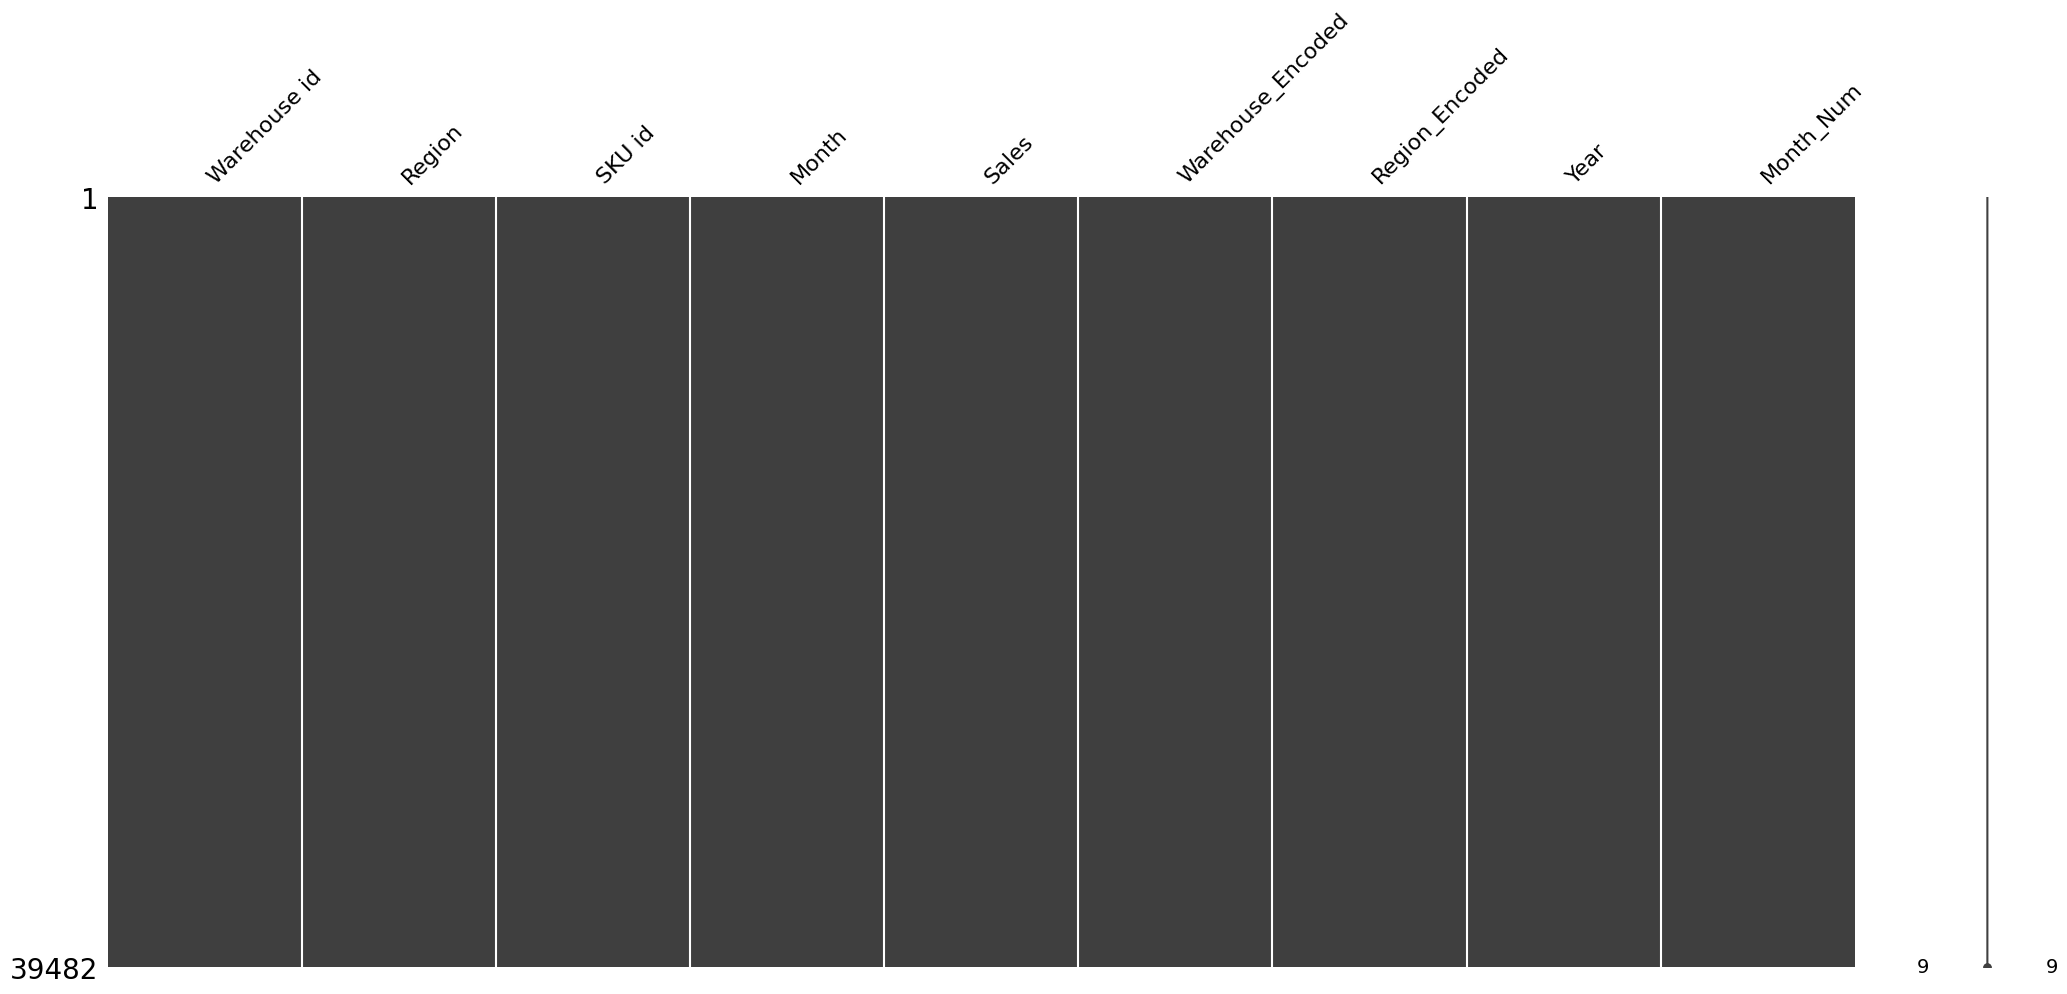

In [ ]:
import missingno as msno

# Visualize missing values
msno.matrix(df_melted)
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import STL

# Decomposing time series for a sample SKU-Warehouse
sample_series = df_melted.groupby("Month")["Sales"].sum()

stl = STL(sample_series, seasonal=13)
result = stl.fit()
result.plot()
plt.show()


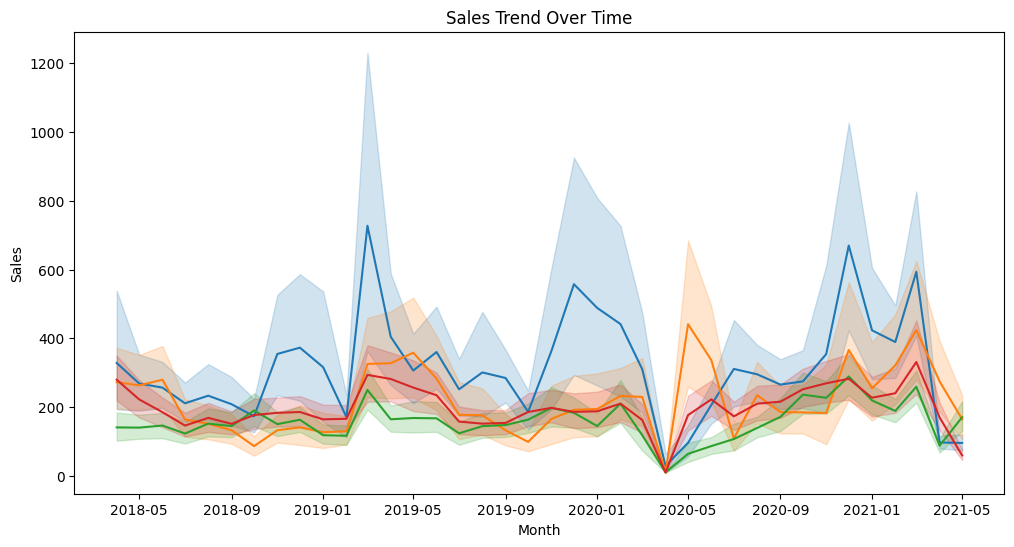

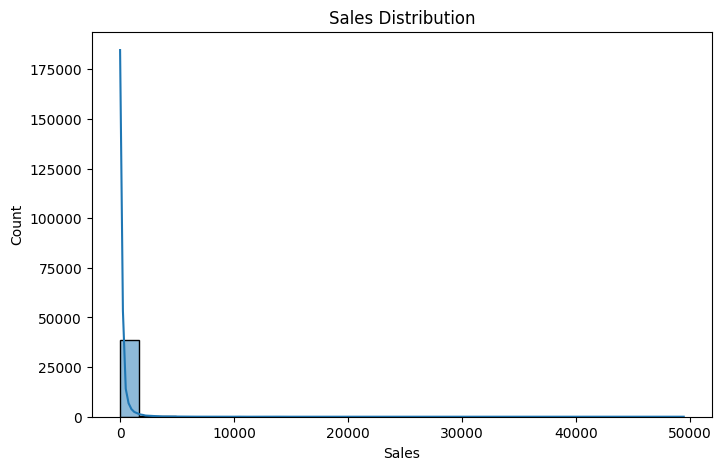

In [ ]:
# Convert wide format to long format
df_melted = df.melt(id_vars=["Warehouse id", "Region", "SKU id"], var_name="Month", value_name="Sales")

# Convert Month column to datetime
df_melted["Month"] = pd.to_datetime(df_melted["Month"], format="%b-%y")

# Sorting data
df_melted.sort_values(by=["Warehouse id", "SKU id", "Month"], inplace=True)

# Basic time series visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x="Month", y="Sales", hue="Region", legend=False)
plt.title("Sales Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

# Distribution of sales
plt.figure(figsize=(8, 5))
sns.histplot(df_melted["Sales"], bins=30, kde=True)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.show()


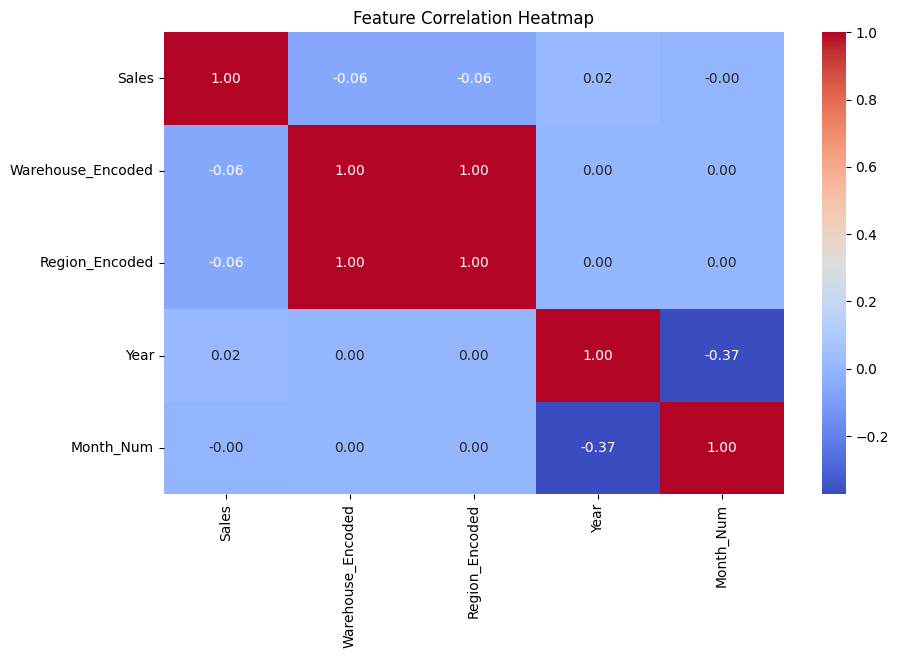

In [ ]:
# Select only numeric columns before calculating correlation
numeric_df = df_melted.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()

# Continue with your heatmap plotting
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# Encoding categorical variables
df_melted["Warehouse_Encoded"], warehouse_map = pd.factorize(df_melted["Warehouse id"])
df_melted["Region_Encoded"], region_map = pd.factorize(df_melted["Region"])

# Extract year and month number
df_melted["Year"] = df_melted["Month"].dt.year
df_melted["Month_Num"] = df_melted["Month"].dt.month


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Checking for stationarity
adf_result = adfuller(sample_series)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: -4.1216587839855325
p-value: 0.0008916941668192255


In [ ]:
df_melted["Quarter"] = df_melted["Month"].dt.quarter
df_melted["Day_of_Year"] = df_melted["Month"].dt.dayofyear
df_melted["Is_Year_End"] = df_melted["Month"].dt.is_year_end.astype(int)
df_melted["Is_Year_Start"] = df_melted["Month"].dt.is_year_start.astype(int)


In [ ]:
df_melted["Sales_Lag1"] = df_melted["Sales"].shift(1)
df_melted["Sales_Lag12"] = df_melted["Sales"].shift(12)  # One year back
df_melted.dropna(inplace=True)  # Remove NaNs caused by shifts


In [ ]:
# Configuration
forecast_year = 2021
forecast_month = 6
min_obs_for_modeling = 25  # Minimum observations needed for modeling

final_predictions = []
mape_values = []
groups = list(df_melted.groupby(["Warehouse id", "SKU id"]))

print(f"Processing {len(groups)} Warehouse-SKU combinations...")

for (warehouse, sku), group in tqdm(groups, desc="Modeling"):
    group = group.set_index("Month").sort_index()

    # Skip if insufficient data
    if len(group) < min_obs_for_modeling:
        final_predictions.append([warehouse, sku, forecast_year, forecast_month, np.nan])
        continue

    try:
        # Train SARIMA Model
        sarima_model = SARIMAX(group["Sales"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_result = sarima_model.fit(disp=False)

        # Get SARIMA residuals
        sarima_fitted = sarima_result.predict(start=group.index[0], end=group.index[-1])
        residuals = group["Sales"] - sarima_fitted
        residuals.fillna(0, inplace=True)

        # Prepare Data for XGBoost
        X = group[["Year", "Month_Num", "Warehouse_Encoded", "Region_Encoded"]]
        y = residuals

        # Train XGBoost
        xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, objective="reg:squarederror", random_state=42)
        xgb_model.fit(X, y)

        # Forecast for June 2021
        sarima_forecast = sarima_result.get_forecast(steps=1).predicted_mean.iloc[0]

        # Forecast Residual Correction using XGBoost
        X_future = pd.DataFrame({"Year": [forecast_year], "Month_Num": [forecast_month],
                                 "Warehouse_Encoded": [group["Warehouse_Encoded"].iloc[0]],
                                 "Region_Encoded": [group["Region_Encoded"].iloc[0]]})
        xgb_forecast = xgb_model.predict(X_future)[0]

        # Final Prediction
        final_sales = max(0, sarima_forecast + xgb_forecast)

        # Store result
        final_predictions.append([warehouse, sku, forecast_year, forecast_month, final_sales])

        # Compute MAPE
        mape = mean_absolute_percentage_error(group["Sales"], sarima_fitted)
        mape_values.append(mape)

    except Exception as e:
        print(f"Error processing Warehouse {warehouse}, SKU {sku}: {e}")
        final_predictions.append([warehouse, sku, forecast_year, forecast_month, np.nan])

print("Modeling Complete!")


Processing 1039 Warehouse-SKU combinations...


Modeling:   0%|          | 0/1039 [00:00<?, ?it/s]

Modeling Complete!


In [ ]:
# Convert results to DataFrame
final_df = pd.DataFrame(final_predictions, columns=["Warehouse id", "SKU id", "Year", "Month", "Predicted Sales"])

# Save to CSV
output_file = "/content/output.csv"
final_df.to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")


Predictions saved to /content/output.csv
